# **INTRODUCTION**
This is my first project on Generative Adversarial Network. The Dataset that I used is EMNIST. I chose the balanced dataset. This project aims to generate a realistic handwritten character (numbers 0 to 9 and alphabets). To be specific this project uses cGAN (Conditional GAN) to gain control on type of output. I learned a lot from this [website](https://towardsdatascience.com/cgan-conditional-generative-adversarial-network-how-to-gain-control-over-gan-outputs-b30620bd0cc8). If you liked the notebook, do upvote. Also provide any feedbacks over any improvements that can be made or some mistake.
Thanks!


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [3]:
TRAIN_PATH_CSV = '/kaggle/input/emnist/emnist-balanced-train.csv'
TEST_PATH_CSV = '/kaggle/input/emnist/emnist-balanced-test.csv'
MAPPING_PATH = '/kaggle/input/emnist/emnist-balanced-mapping.txt'
NUM_CLASSES = 47

# **DATA AND PREPROCESSING**

Get the train, test and mapping data from balanced dataset.

In [4]:
train_data = pd.read_csv(TRAIN_PATH_CSV, header = None)
test_data = pd.read_csv(TEST_PATH_CSV, header = None)
mapping = pd.read_csv(MAPPING_PATH,sep = ' ', header = None)

Our data is in form of CSV. Each row has 785 columns. The first column represents the character(an A or a B). The next 784 columns is the image of the character whose size is 28X28 flattened to 784 columns.

In [5]:
print("Shape of train_data is :",train_data.shape)
print("Shape of test_data is :",test_data.shape)

Shape of train_data is : (112800, 785)
Shape of test_data is : (18800, 785)


In [6]:
train_data.rename(columns= {0: 'label'}, inplace = True)
test_data.rename(columns= {0: 'label'}, inplace = True)
train_data.columns


Index(['label',       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           775,     776,     777,     778,     779,     780,     781,     782,
           783,     784],
      dtype='object', length=785)

In [7]:
Y_train = train_data['label']
Y_train = Y_train.values.reshape(train_data.shape[0],1).astype('float32')

X_train = train_data.drop(columns = 'label')
X_train = X_train.values.reshape(train_data.shape[0],28,28,1).astype('float32')

Y_test = test_data['label']
Y_test = Y_test.values.reshape(test_data.shape[0],1).astype('float32')

X_test = test_data.drop(columns = 'label')
X_test = X_test.values.reshape(test_data.shape[0],28,28,1).astype('float32')

mapping = mapping.values

Data has been split into train and test sets properly. Now we display some of them.

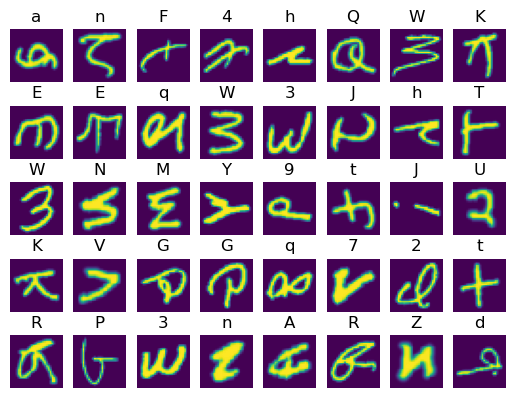

In [8]:
height = 5
width = 8

for i in range(height):
    for j in range(width):
        n = 20*i + j + 1
        plt.subplot(height, width, width * i + j + 1)
        plt.imshow(X_train[n])
        character = chr(mapping[int(Y_train[n])][1])
        plt.gca().set_title(character)
        plt.axis('off')


Normalize.

In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

# **MAKING THE MODEL**

In [10]:
import math
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense, Embedding, Reshape, Concatenate, MaxPooling2D
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, ReLU, Dropout, Flatten, LeakyReLU, BatchNormalization
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

[Normal GAN architecture](https://towardsdatascience.com/cgan-conditional-generative-adversarial-network-how-to-gain-control-over-gan-outputs-b30620bd0cc8)![Normal GAN architecture](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*ZKUo2QtHasnr8-RiqeJ_YA.png)

[CGAN architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*yO9fLGCR9mOgTVWUKiYQSQ.png)![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*yO9fLGCR9mOgTVWUKiYQSQ.png)

I imagine a GAN's model as a competition between an artwork Appraiser (the person whose job is check if a painting is real and appraise its value) and a Forger (who makes fake paintings and wants to make it less distinguishable from real paintings).

Appraiser is the Discriminator model and Forger is the Generator model in GAN. The Appraiser is learning and knows some basics of distinguishing a fake from real but he also learns some new things while working.

The Forger tries to make real paintings and copies different artists. When he fails, he changes his artstyle a little. That is, he improves himself.

In this continous cycle, both the Forger and Appraiser become better at job. Forger makes indistinguishable paintaings of any artists he likes, and Appraiser finds the fake.

After some time Forger has become so good at his work, that he himself has become a very good artist. He can now replicate other people's work. Our Forger became an expert artist.

This is how Generator model generates realistic fakes.

Credits : [Link](https://www.cloud-science.de/wp-content/uploads/2022/05/GENERATIVE-ADVERSARIAL-NETWORK-GAN-Cartoon-web.png)![](https://www.cloud-science.de/wp-content/uploads/2022/05/GENERATIVE-ADVERSARIAL-NETWORK-GAN-Cartoon-web.png)

In [11]:
#Generator generates the fake images
def Generator(Noise_Dim=(100,) , ):
    #Generator takes two inputs, one is the label ,type of character
    #the other is a random noise array which becomes the image
    LabelInput = Input((1,), name='Label_Input')
    NoiseInput = Input(Noise_Dim, name='Noise_Input')
    
    side = 7
    f1 = 32
    f2 = 32
    
    Label = Dense(side*side*f1, name='Dense_Label')(LabelInput)
    Label = Reshape((side,side,f1), name='Reshape_Label')(Label)
    
    Noise = Dense(side*side*f2, name='Dense_Noise')(NoiseInput)
    Noise = Reshape((side,side,f2), name='Reshape_Noise')(Noise)
    
    Concat1 = Concatenate(name='Concat')([Label,Noise])
    
    x = Conv2DTranspose(128, 4, 2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='Conv_Transpose_1')(Concat1)
    x = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='BN_1')(x)
    x = ReLU(name='ReLU_1')(x)
     
    x = Conv2DTranspose(64, 4, 2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='Conv_Transpose_2')(x)
    x = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='BN_2')(x)
    x = ReLU(name='ReLU_2')(x)
     
    x = Conv2DTranspose(64, 4, 2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='Conv_Transpose_3')(x)
    x = BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='BN_3')(x)
    x = ReLU(name='ReLU_3')(x)
   
 
    x = Conv2DTranspose(64, 4, 2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='Conv_Transpose_4')(x)
    x = BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='BN_4')(x)
    x = ReLU(name='ReLU_4')(x) 
    
    x = Conv2D(128, 4, 2, padding='same', name='Conv2D_1')(x)
    x = BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='BN_5')(x)
    x = ReLU(name='reLU_5')(x)
    
    x = Conv2D(64 , 4, 1, padding='same', name='Conv2D_2')(x)
    x = BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='BN_6')(x)
    x = ReLU(name='ReLU_6')(x)
    
    x = Conv2D(16, 2, 1, padding='same', name='Conv2D_3')(x)
    x = BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='BN_7')(x)
    x = ReLU(name='ReLU_7')(x)
    
    x = Conv2D(1, 1, 2, padding='same', name='Conv2D_4')(x)
    x = BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='BN_8')(x)
    x = ReLU(name='ReLU_8')(x)
    
   # define model
    model = Model([LabelInput, NoiseInput], x)
    return model

In [12]:
Gen = Generator()
Gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Label_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Noise_Input (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 Dense_Label (Dense)            (None, 1568)         3136        ['Label_Input[0][0]']            
                                                                                                  
 Dense_Noise (Dense)            (None, 1568)         158368      ['Noise_Input[0][0]']            
                                                                                              

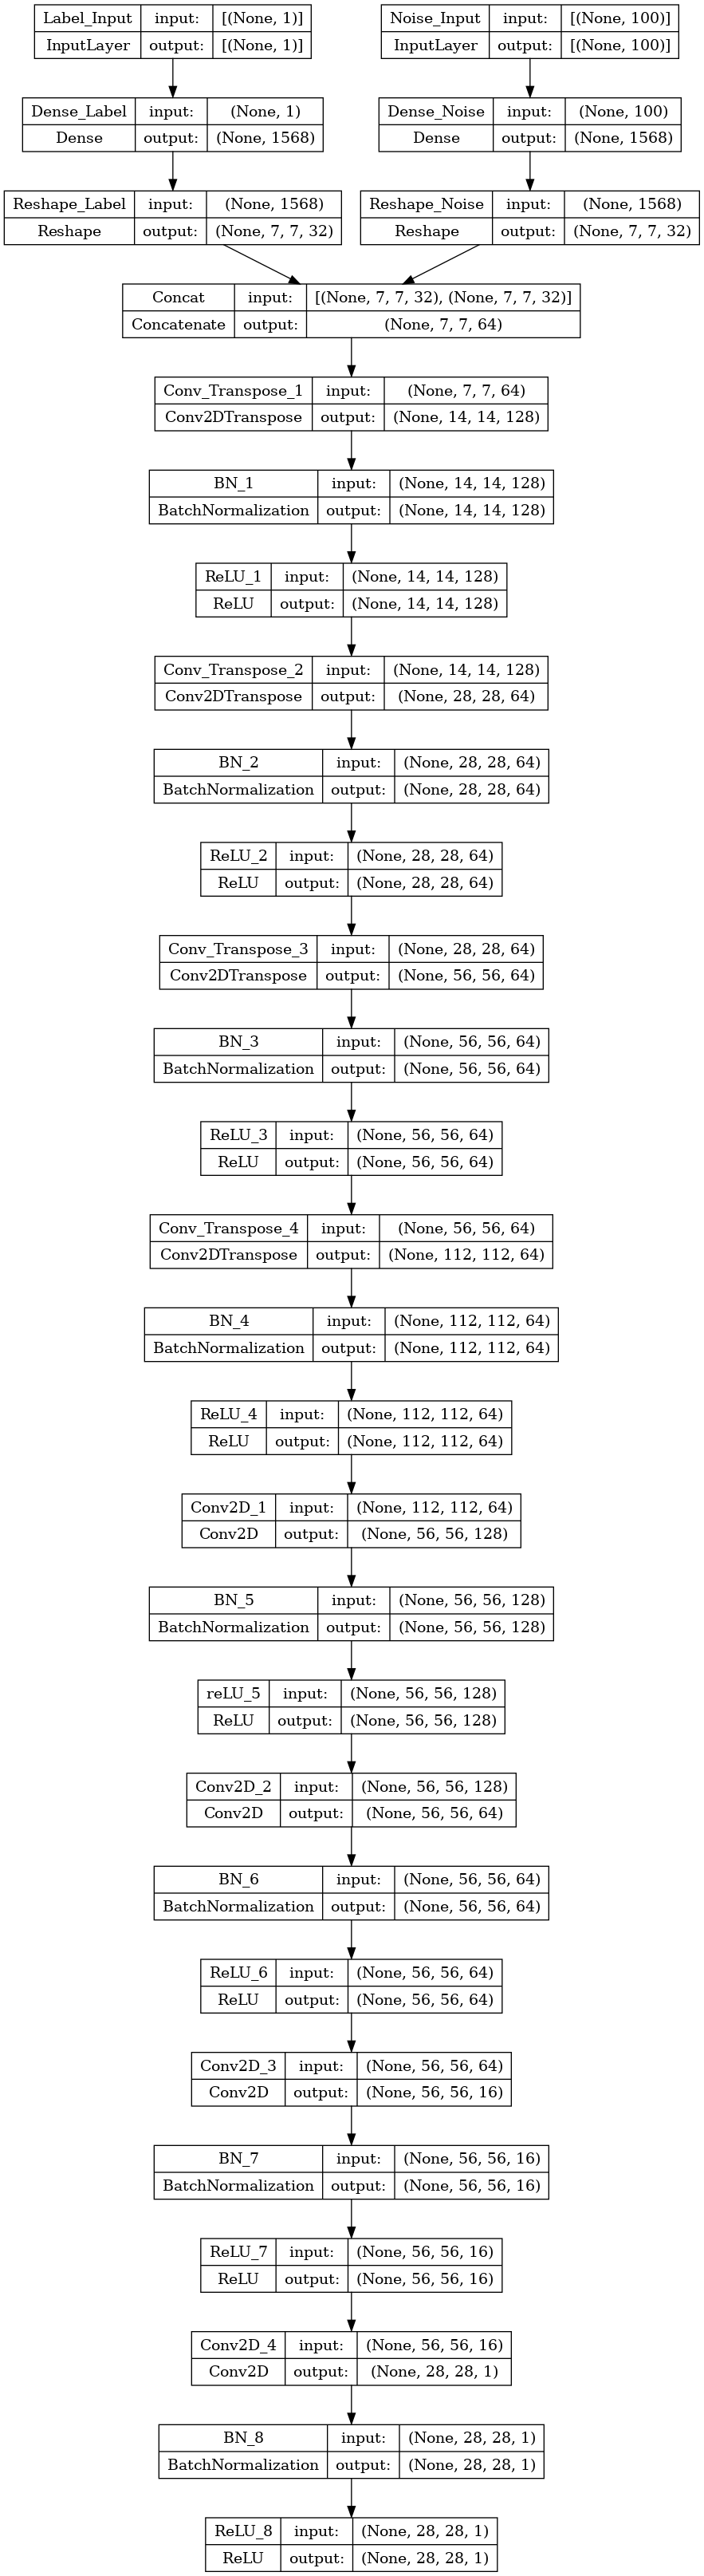

In [22]:
#Generator model plot
plot_model(Gen, show_shapes=True, to_file='Generator_model.png')

In [16]:
#Discriminator finds the real and fake images. A real image is a 1
def Discriminator(Img_Dim=(28,28,1)):
    #Discriminator also takes 2 inputs
    #One is the label and other is the Image that it needs to identify as real or fake
    LabelInput = Input((1,), name='Label_Input')
    ImgInput = Input(Img_Dim, name='Img_Input')
    
    Label = Dense(32, name='Dense_Label_1')(LabelInput)
    Label = Dense(3136, name='Dense_Label_2')(Label)
    Label = Reshape((28,28,4))(Label)

    Img = Conv2D(7, 3 , padding='same', name='Conv2D_Img_1')(ImgInput)
    Img = Conv2D(14, 3 , padding='same', name='Conv2D_Img_2')(Img)
    Img = Conv2D(28, 3 , padding='same', name='Conv2D_Img_3')(Img)
    
    x = Concatenate()([Label,Img])
    
    x = Conv2D(64, 4, 2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='Conv_1')(x)
    x = LeakyReLU(0.2, name='Leaky_ReLU_1')(x)
    
    x = Conv2D(128, 4, 3, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='Conv_2')(x)
    x = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='BN_1')(x)
    x = LeakyReLU(0.2, name='Leaky_ReLU_2')(x)
    
    x = Conv2D(256, 4, 3, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='Conv_3')(x)
    x = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='BN_2')(x)
    x = LeakyReLU(0.2, name='Leaky_ReLU_3')(x)
    
    x = Conv2D(256, 4, 3, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='Conv_4')(x)
    x = BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='BN_3')(x)
    x = LeakyReLU(0.2, name='Leaky_ReLU_4')(x)
    
    x = Flatten(name='Flatten')(x)
    x = Dropout(0.4, name='Dropout')(x)
    x = Dense(1, activation='sigmoid', name='Dense')(x)
    
    Discriminator_Model = Model([LabelInput, ImgInput], x)
    Discriminator_Model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.002, beta_1=0.5), metrics=['accuracy'])
    return Discriminator_Model

In [17]:
Dis = Discriminator()
Dis.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Label_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Img_Input (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Dense_Label_1 (Dense)          (None, 32)           64          ['Label_Input[0][0]']            
                                                                                                  
 Conv2D_Img_1 (Conv2D)          (None, 28, 28, 7)    70          ['Img_Input[0][0]']              
                                                                                            

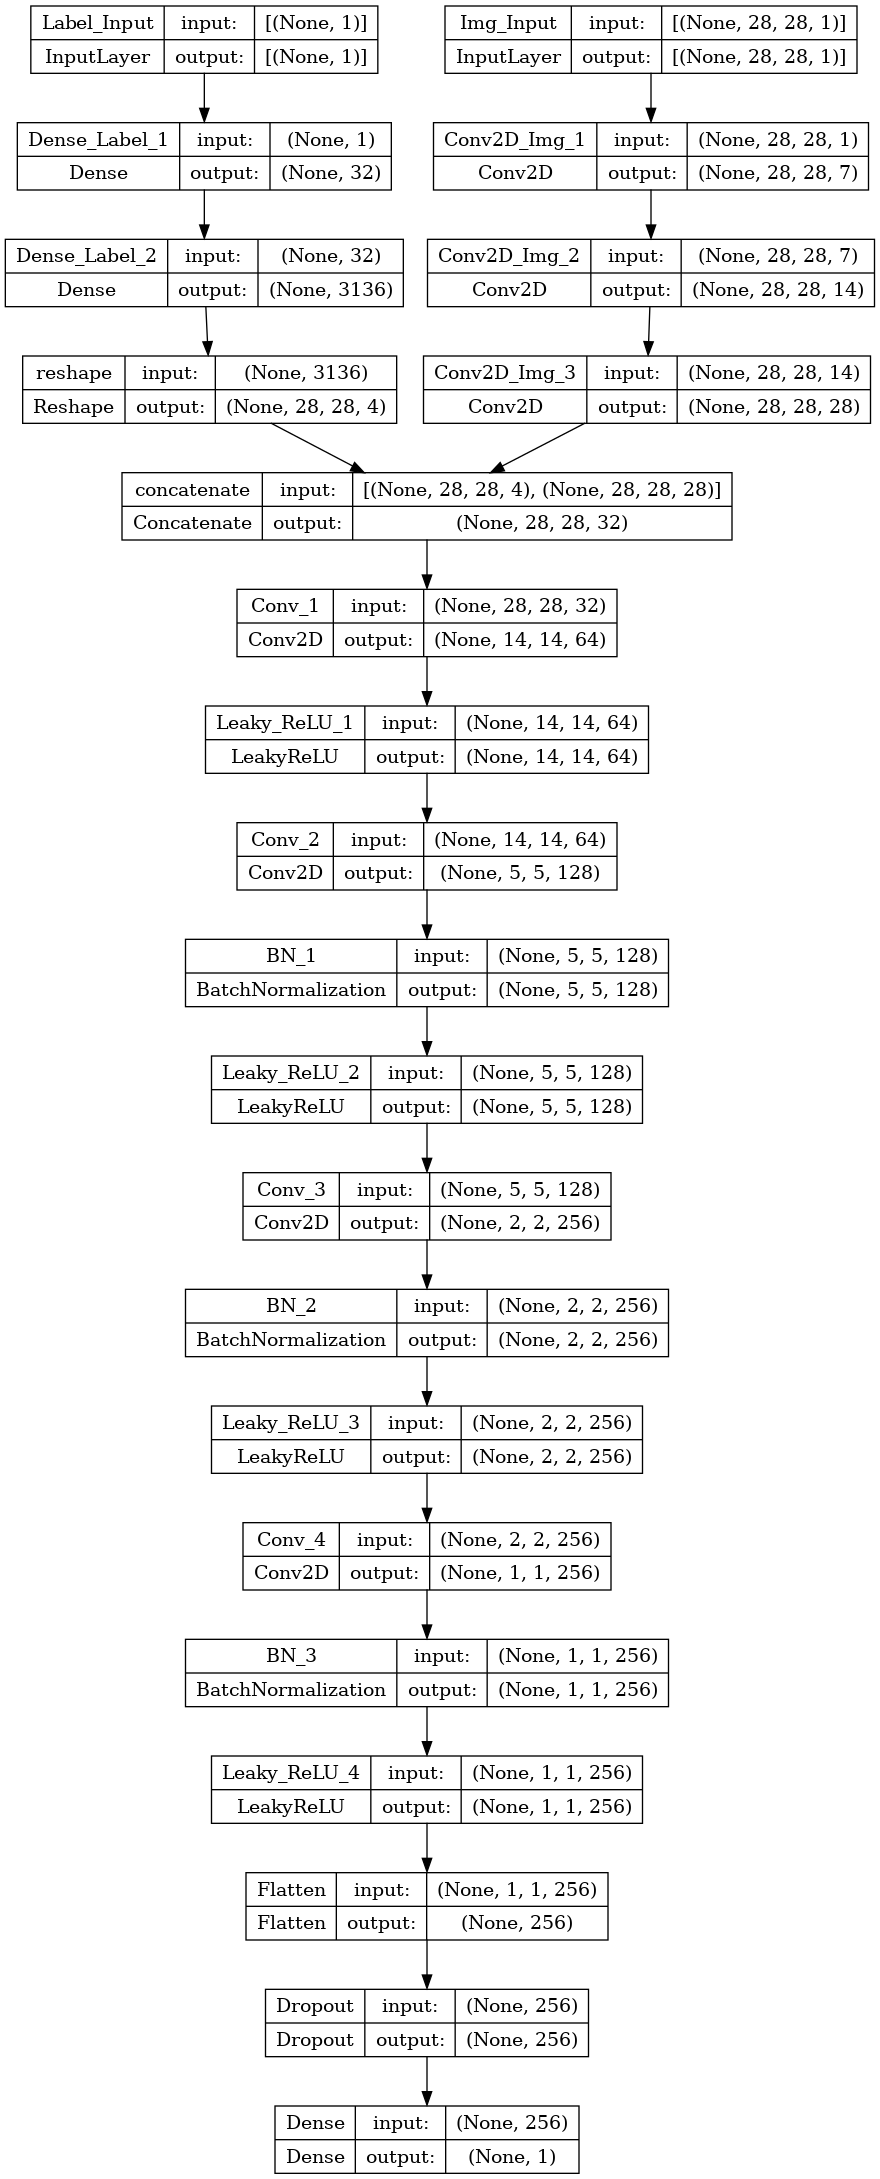

In [23]:
#Discriminator Model plot
plot_model(Dis, show_shapes=True, to_file='Discriminator_model.png')

In [19]:
#Merge both the models to get cGAN
def CGAN(Generator_Model, Discriminator_Model):
    #We dont want to train it initially
    Discriminator_Model.trainable = False
    
    #Getting generator model inputs and outputs
    GeneratorLabelInput, GeneratorNoiseInput = Generator_Model.input
    GeneratorImgOutput = Generator_Model.output
    
    #Generators image go into discriminator
    DiscriminatorOutput = Discriminator_Model([GeneratorLabelInput, GeneratorImgOutput])
    
    #CGAN takes label and Generator noise from starting as input
    #and verdict from discriminator as output
    CGAN_Model = Model([GeneratorLabelInput, GeneratorNoiseInput], DiscriminatorOutput)
    
    CGAN_Model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.002, beta_1=0.5))
    return CGAN_Model

In [20]:
CGAN_Model = CGAN(Gen,Dis)
CGAN_Model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Label_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Noise_Input (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 Dense_Label (Dense)            (None, 1568)         3136        ['Label_Input[0][0]']            
                                                                                                  
 Dense_Noise (Dense)            (None, 1568)         158368      ['Noise_Input[0][0]']            
                                                                                            

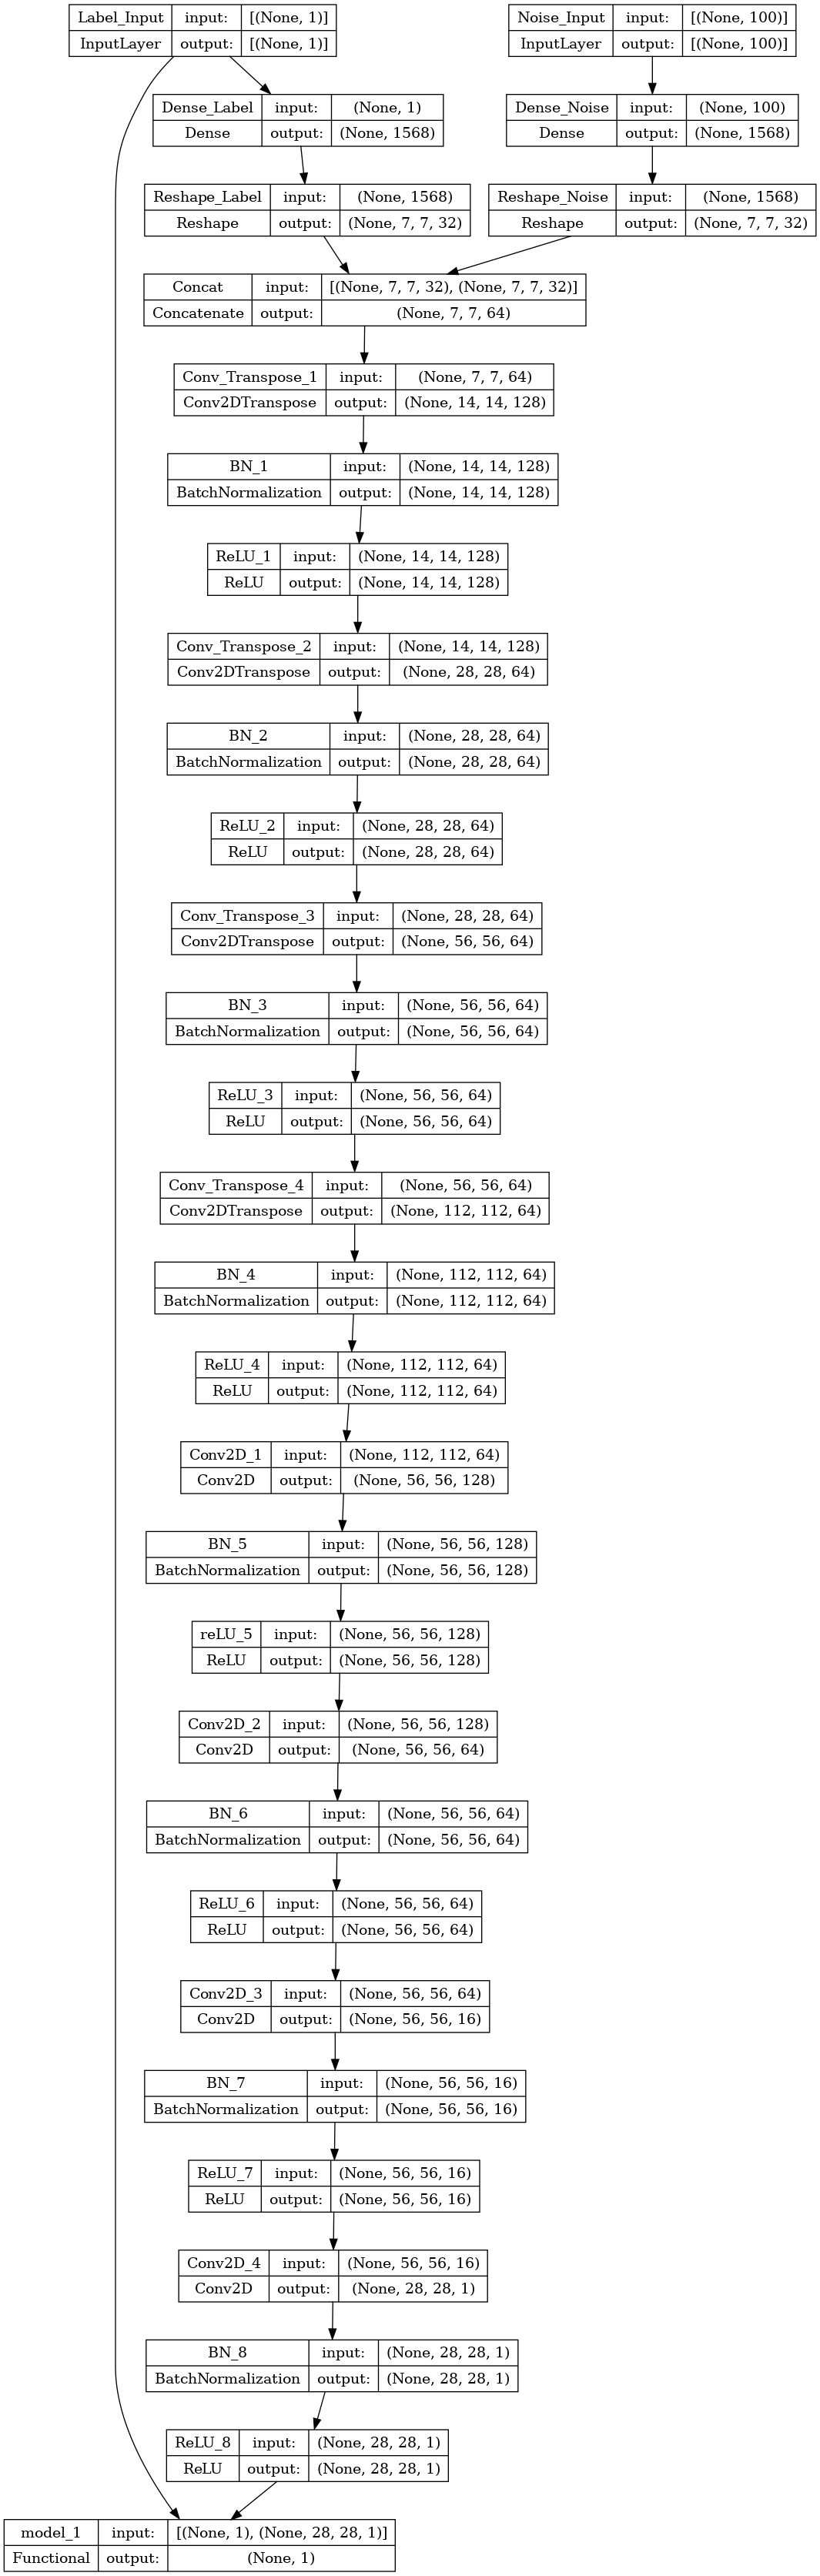

In [24]:
#cGAN model plot
plot_model(CGAN_Model, show_shapes=True,show_layer_names=True,to_file='cGAN_model.png')

In [21]:
#Real sample, i.e., from the dataset , X_train
def real_sample(n, data, mapping):
    #Take some random indexes in dataset
    rand_ind = np.random.randint(0,data.shape[0],n)
    
    #Collect data at these random indexes
    X = data[rand_ind]
    Label = mapping[rand_ind]
    Y = np.ones((n,1))
    
    return X, Y, Label

In [22]:
#This just generates a noise vector along with a random label
def random_noise(n,Noise_Dim=100):
    random_val = np.random.randn(Noise_Dim*n)
    random_val = random_val.reshape(n, Noise_Dim)
    random_label = np.random.randint(0,NUM_CLASSES,n)
    random_label.reshape(n,1)
    
    return random_val, random_label

In [23]:
#This generates a fake sample using Generator's help
def fake_sample(n,Generator_Model,Noise_Dim=100):
    random_val , random_label = random_noise(n,Noise_Dim)
    
    X = Generator_Model.predict([random_label , random_val])
    Y = np.zeros((n,1))
    
    return X,Y,random_label

In [24]:
#A function to visualise our Generator's performance
#Expectation is that during early stages generator just gives some noise
#On later stage it should give characters that look real
def Generator_Image(Generator_Model,length,width,Noise_Dim=100):
    img, Y_fake, labels_fake = fake_sample(length*width,Generator_Model,Noise_Dim)
    #Making a subplot to show width X height number of images
    fig, axs = plt.subplots(height, width)
    for i in range(height):
        for j in range(width):
            n = i * width + j
            axs[i, j].imshow(img[n], cmap='gray')
            axs[i, j].axis('off')
            character = chr(mapping[int(labels_fake[n])][1])
            axs[i, j].set_title(character)
    plt.show()

In [25]:
def train(Generator_Model, Discriminator_Model, GAN_Model,Data, LabelMapping, Noise_Dim=50, Num_Epochs=6, Num_Batch=256):
    #Number of batched per epoch
    Batch_per_epoch = int(Data.shape[0] / Num_Batch)
    print('Batch per epoch : ',Batch_per_epoch)
    
    #Dividing batch because Discriminator first trains on real images
    #then on fake images
    Half_batch = int(Num_Batch/2)
    
    for i in range(Num_Epochs):
        print('________________________\nEpoch : %d/%d \n'%(i+1,Num_Epochs))
        for j in range(Batch_per_epoch):
        #Discriminator Training
            #Real Samples
            X_Real, Y_Real, Label_Real = real_sample(Half_batch, Data, LabelMapping)
            Discriminator_Loss1, _ = Discriminator_Model.train_on_batch([Label_Real, X_Real], Y_Real)
            
            #Fake Samples
            X_Fake,Y_Fake,Label_Fake = fake_sample(Half_batch,Generator_Model,Noise_Dim)
            Discriminator_Loss2, _ = Discriminator_Model.train_on_batch([Label_Fake, X_Fake], Y_Fake)
            
        #Generator Training
            random_val, random_label = random_noise(Num_Batch,Noise_Dim)
            Y = np.ones((Num_Batch, 1))
            Generator_Loss = GAN_Model.train_on_batch([random_label, random_val], Y)
            print('Batch: %d/%d, D_Loss_Real=%.3f, D_Loss_Fake=%.3f Gen_Loss=%.3f' %  (j+1, Batch_per_epoch, Discriminator_Loss1, Discriminator_Loss2, Generator_Loss))
        Generator_Image(Generator_Model,5,5,Noise_Dim)

        

Batch per epoch :  220
________________________
Epoch : 1/20 

8/8 [==============================] - 1s 11ms/step
Batch: 1/220, D_Loss_Real=0.692, D_Loss_Fake=0.772 Gen_Loss=0.545
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.774, D_Loss_Fake=0.796 Gen_Loss=0.605
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.867, D_Loss_Fake=0.980 Gen_Loss=0.712
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.774, D_Loss_Fake=0.645 Gen_Loss=0.797
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.802, D_Loss_Fake=1.585 Gen_Loss=0.543
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.907, D_Loss_Fake=0.714 Gen_Loss=0.557
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.473, D_Loss_Fake=0.738 Gen_Loss=0.479
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.298, D_Loss_Fake=0.785 Gen_Loss

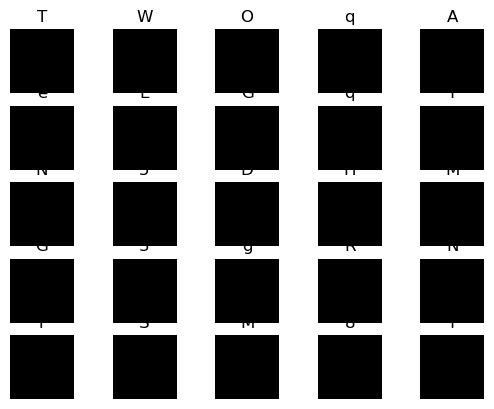

________________________
Epoch : 2/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.023, D_Loss_Fake=0.015 Gen_Loss=0.053
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.021, D_Loss_Fake=0.018 Gen_Loss=0.042
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.020, D_Loss_Fake=0.021 Gen_Loss=0.053
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.021, D_Loss_Fake=0.015 Gen_Loss=0.041
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.019, D_Loss_Fake=0.017 Gen_Loss=0.047
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.022, D_Loss_Fake=0.015 Gen_Loss=0.041
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.022, D_Loss_Fake=0.016 Gen_Loss=0.034
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.023, D_Loss_Fake=0.019 Gen_Loss=0.035
8/8 [===========

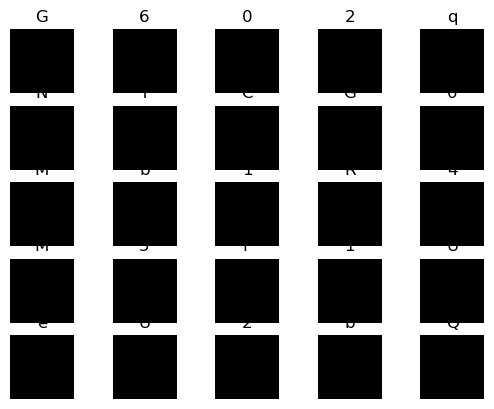

________________________
Epoch : 3/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.026, D_Loss_Fake=0.103 Gen_Loss=0.007
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.025, D_Loss_Fake=0.101 Gen_Loss=0.007
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.029, D_Loss_Fake=0.101 Gen_Loss=0.005
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.023, D_Loss_Fake=0.094 Gen_Loss=0.007
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.022, D_Loss_Fake=0.095 Gen_Loss=0.006
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.025, D_Loss_Fake=0.092 Gen_Loss=0.008
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.029, D_Loss_Fake=0.089 Gen_Loss=0.007
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.026, D_Loss_Fake=0.085 Gen_Loss=0.007
8/8 [===========

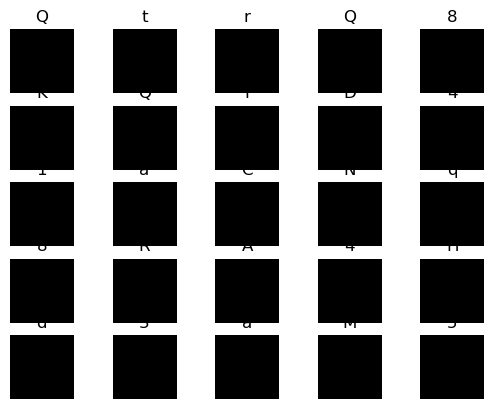

________________________
Epoch : 4/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.007, D_Loss_Fake=0.014 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.008, D_Loss_Fake=0.014 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.008, D_Loss_Fake=0.014 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.009, D_Loss_Fake=0.014 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.006, D_Loss_Fake=0.014 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.015, D_Loss_Fake=0.014 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.011, D_Loss_Fake=0.013 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.006, D_Loss_Fake=0.014 Gen_Loss=0.000
8/8 [===========

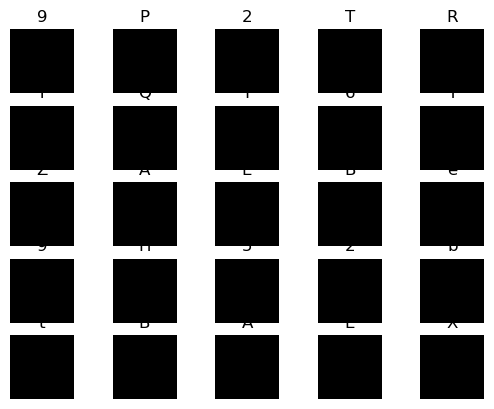

________________________
Epoch : 5/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.003, D_Loss_Fake=0.006 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.002, D_Loss_Fake=0.006 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.003, D_Loss_Fake=0.007 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.009, D_Loss_Fake=0.006 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.008, D_Loss_Fake=0.006 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.002, D_Loss_Fake=0.006 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.003, D_Loss_Fake=0.006 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.004, D_Loss_Fake=0.006 Gen_Loss=0.001
8/8 [===========

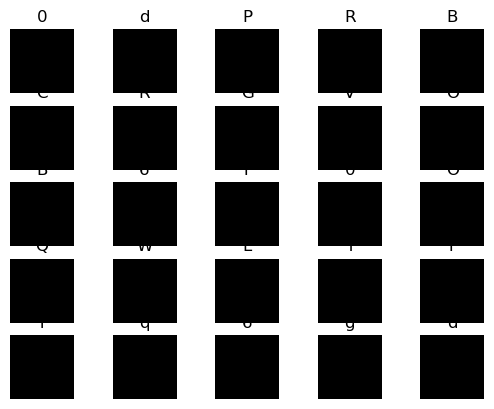

________________________
Epoch : 6/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.001, D_Loss_Fake=0.004 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.003, D_Loss_Fake=0.003 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.002, D_Loss_Fake=0.004 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.002, D_Loss_Fake=0.003 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.002, D_Loss_Fake=0.003 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.003, D_Loss_Fake=0.003 Gen_Loss=0.002
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.002, D_Loss_Fake=0.003 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.003, D_Loss_Fake=0.004 Gen_Loss=0.001
8/8 [===========

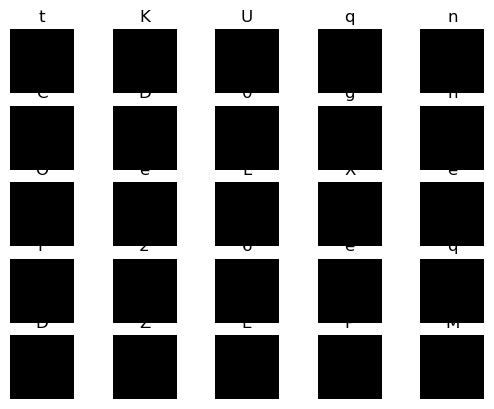

________________________
Epoch : 7/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.000, D_Loss_Fake=0.002 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.002, D_Loss_Fake=0.002 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.001
8/8 [===========

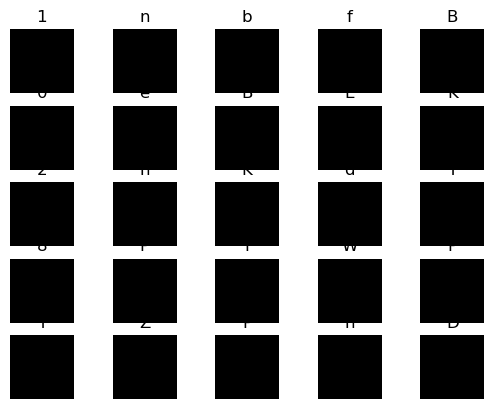

________________________
Epoch : 8/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.001
8/8 [===========

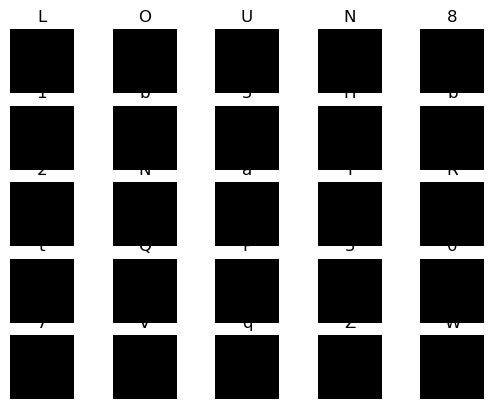

________________________
Epoch : 9/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.001
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.000
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.000
8/8 [===========

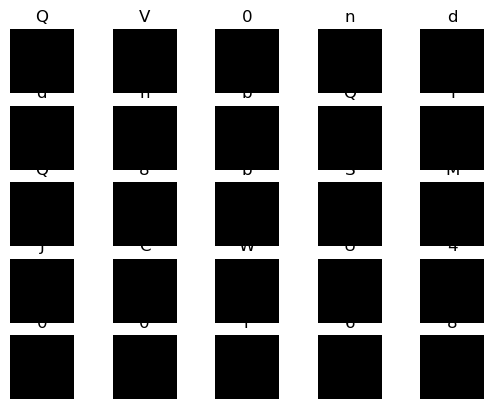

________________________
Epoch : 10/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.001, D_Loss_Fake=0.008 Gen_Loss=0.164
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.002, D_Loss_Fake=0.007 Gen_Loss=0.151
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.001, D_Loss_Fake=0.007 Gen_Loss=0.209
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.001, D_Loss_Fake=0.008 Gen_Loss=0.239
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.002, D_Loss_Fake=0.007 Gen_Loss=0.254
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.001, D_Loss_Fake=0.007 Gen_Loss=0.192
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.001, D_Loss_Fake=0.007 Gen_Loss=0.276
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.001, D_Loss_Fake=0.007 Gen_Loss=0.266
8/8 [==========

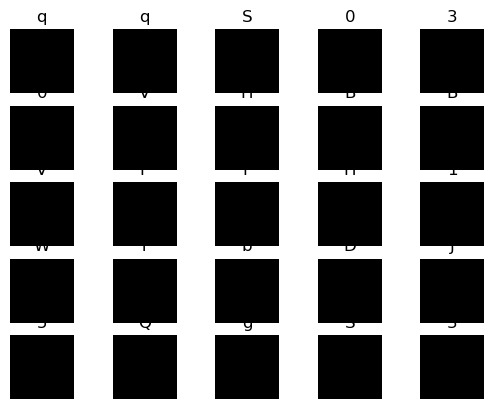

________________________
Epoch : 11/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.000, D_Loss_Fake=0.002 Gen_Loss=0.341
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.375
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.357
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.000, D_Loss_Fake=0.002 Gen_Loss=0.411
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.362
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.001, D_Loss_Fake=0.002 Gen_Loss=0.269
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.002, D_Loss_Fake=0.002 Gen_Loss=0.283
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.000, D_Loss_Fake=0.002 Gen_Loss=0.271
8/8 [==========

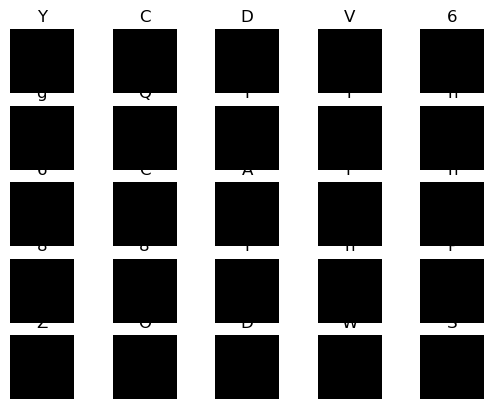

________________________
Epoch : 12/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.336
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.400
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.575
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.471
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.472
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.399
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.477
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.427
8/8 [==========

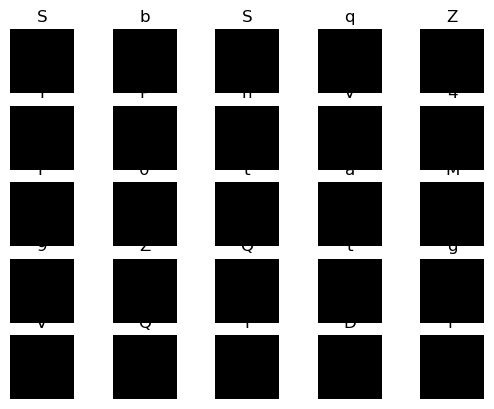

________________________
Epoch : 13/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.278
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.344
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.327
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.354
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.351
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.425
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.435
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.517
8/8 [==========

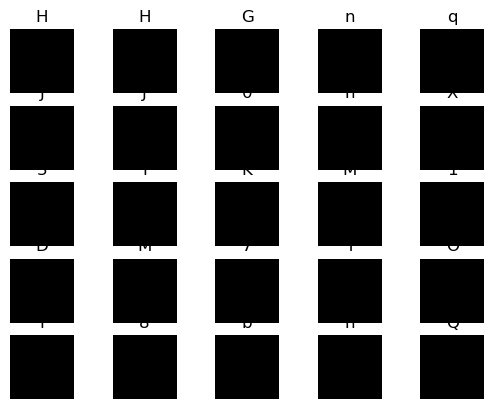

________________________
Epoch : 14/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=1.031
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.003, D_Loss_Fake=0.001 Gen_Loss=0.334
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.604
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.757
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.824
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.836
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.001, D_Loss_Fake=0.001 Gen_Loss=0.548
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.000, D_Loss_Fake=0.001 Gen_Loss=0.641
8/8 [==========

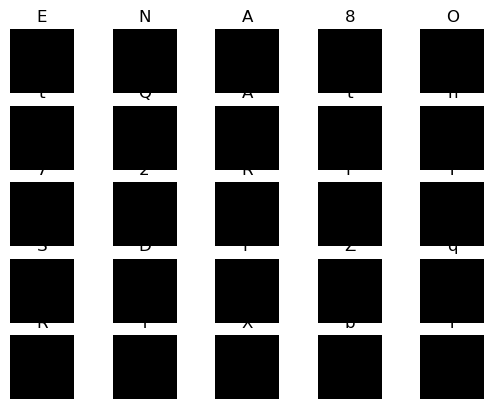

________________________
Epoch : 15/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.864
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.855
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.847
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.872
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.743
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.779
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.012
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.835
8/8 [==========

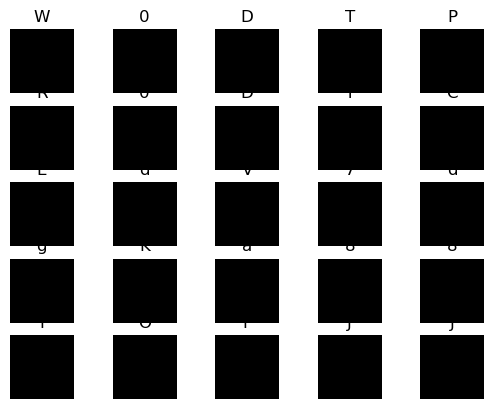

________________________
Epoch : 16/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.915
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.961
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.994
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.917
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.975
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.951
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.732
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.871
8/8 [==========

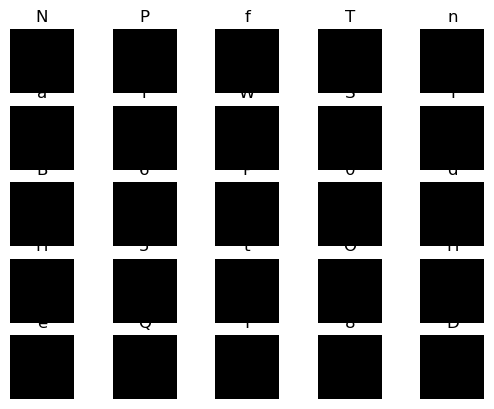

________________________
Epoch : 17/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.730
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.854
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.746
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.785
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.765
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.600
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.869
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.867
8/8 [==========

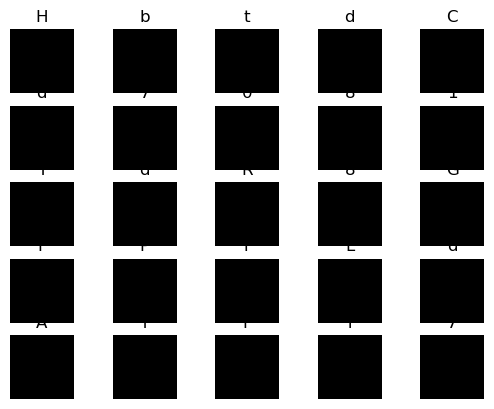

________________________
Epoch : 18/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.732
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.002, D_Loss_Fake=0.000 Gen_Loss=2.859
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=2.350
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.837
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.445
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.361
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.271
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.004, D_Loss_Fake=0.000 Gen_Loss=0.139
8/8 [==========

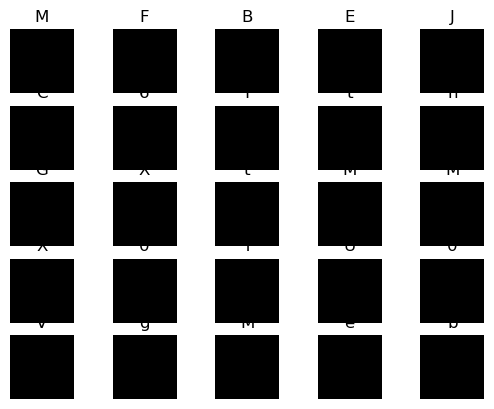

________________________
Epoch : 19/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.068
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.954
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.956
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.978
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.008
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.964
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.024
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.915
8/8 [==========

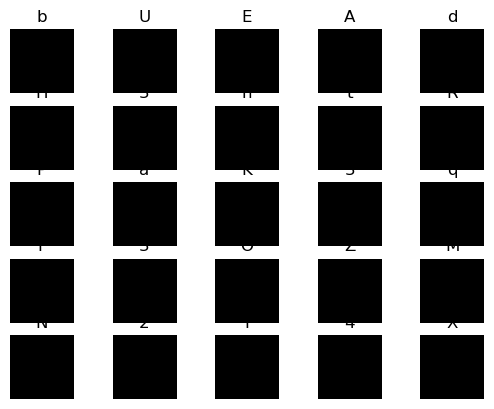

________________________
Epoch : 20/20 

8/8 [==============================] - 0s 12ms/step
Batch: 1/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.917
8/8 [==============================] - 0s 12ms/step
Batch: 2/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.234
8/8 [==============================] - 0s 12ms/step
Batch: 3/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=0.920
8/8 [==============================] - 0s 12ms/step
Batch: 4/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.124
8/8 [==============================] - 0s 12ms/step
Batch: 5/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.186
8/8 [==============================] - 0s 12ms/step
Batch: 6/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.108
8/8 [==============================] - 0s 12ms/step
Batch: 7/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.161
8/8 [==============================] - 0s 12ms/step
Batch: 8/220, D_Loss_Real=0.000, D_Loss_Fake=0.000 Gen_Loss=1.080
8/8 [==========

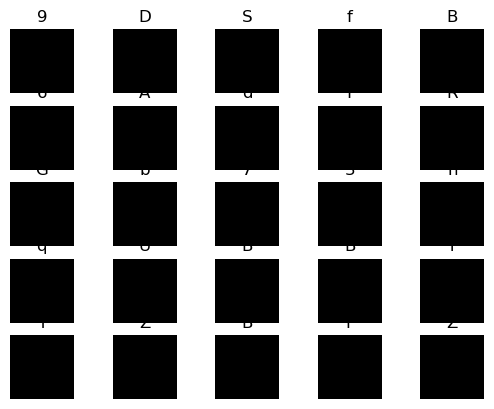

In [26]:
train(Gen, Dis, CGAN_Model ,X_train, Y_train, Noise_Dim=100, Num_Epochs=20, Num_Batch=512)

In [28]:
Gen.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
Gen.save('/kaggle/working/Generator_Model.h5')

In [29]:
Dis.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
Dis.save('/kaggle/working/Discriminator_Model.h5')